In [1]:
import json
import numpy as np
from neuralNetwork import NeuralNetwork, In_between_epochs
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from random import shuffle, randint
from transformers import RobertaModel, RobertaTokenizer, AutoTokenizer, AutoModel
from helper import dict_lists_to_list_of_dicts, get_train_valdiation_test_split, Dataset
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt

In [2]:
f = open("ECHR_Corpus.json",encoding= 'utf-8')
dataset = json.load(f)
f.close()

# Dataset
Dataset organization:
```json
{
    "text":"il testo completo della sentenza"
    "clauses":[
        {
            "_id": "id della clause",
            "start": "index di inizio della clause",
            "end": "index di fine della cluause"
        },
        {
            "...":"..."
        }
    ]
    "argument":[
        {
            "premises":[
                "id premise1", "id premise2", "..."
            ],
            "conclusion": "id conclusion"
        },
        {
            "...":"..."
        }
    ]
}
```

In [3]:
refactored_dataset = []
for datapoint in dataset:
    text = datapoint["text"]
    dict_clauses = {}
    for clause in datapoint["clauses"]:
        start = clause["start"]
        end = clause["end"]
        id = clause["_id"]
        dict_clauses[id] = text[start:end]
    refactored_dataset.append({
        "text": text,
        "arguments": datapoint["arguments"],
        "n_clauses": len(datapoint["clauses"]),
        "all_clauses": dict_clauses
    })

In [4]:
n_arguments = []
n_premises = []
n_clauses = []
for case in refactored_dataset:
    n_arguments.append(len(case["arguments"]))
    n_clauses.append(case["n_clauses"])
    for argument in case["arguments"]:
        n_premises.append(len(argument["premises"]))
print(f"""
On average, a case has {np.mean(n_clauses):.2f} clauses with a median of {np.median(n_clauses):.0f} clauses per case.
On average, a case has {np.mean(n_arguments):.2f} arguments with a median of {np.median(n_arguments):.0f} arguments per case.
Each argument, on average, has: {np.mean(n_premises):.2f} premises with a median of {np.median(n_premises):.0f} premises per argument.
""")


On average, a case has 248.95 clauses with a median of 226 clauses per case.
On average, a case has 17.69 arguments with a median of 14 arguments per case.
Each argument, on average, has: 2.63 premises with a median of 2 premises per argument.



In [5]:
premise = "\n\t".join([refactored_dataset[0]["all_clauses"][premise] for premise in refactored_dataset[0]["arguments"][0]["premises"]])
conclusion = refactored_dataset[0]["all_clauses"][refactored_dataset[0]["arguments"][0]["conclusion"]]
print(f"""
Here an example of an argument:
    - Premises:
        {premise}
    - Conclusion:
        {conclusion}
""")


Here an example of an argument:
    - Premises:
        The Commission notes that the applicant was detained after having been sentenced by the first instance court to 18 months' imprisonment.
	He was released after the Court of Appeal reviewed this sentence, reducing it to 15 months' imprisonment, convertible to a fine.
    - Conclusion:
        The Commission finds that the applicant was deprived of his liberty "after conviction by a competent court" within the meaning of Article 5 para. 1 (a) (Art. 5-1-a) of the Convention.



## Prepare for a task

### 6.1 Argument Clause Recognition

In [6]:
cases = get_train_valdiation_test_split(refactored_dataset, [4])

In [7]:
for i in range(len(cases)):
    train_cases, validation_cases, test_cases = cases[i]
    print(f"""there are {len(train_cases)} cases in the training set (fold {i}), 
    {len(validation_cases)} cases in the validation set (fold {i}) and
    {len(test_cases)} cases in the test set (fold {i})
    """)

there are 28 cases in the training set (fold 0), 
    6 cases in the validation set (fold 0) and
    8 cases in the test set (fold 0)
    
there are 28 cases in the training set (fold 1), 
    6 cases in the validation set (fold 1) and
    8 cases in the test set (fold 1)
    
there are 28 cases in the training set (fold 2), 
    6 cases in the validation set (fold 2) and
    8 cases in the test set (fold 2)
    
there are 28 cases in the training set (fold 3), 
    6 cases in the validation set (fold 3) and
    8 cases in the test set (fold 3)
    
there are 28 cases in the training set (fold 4), 
    6 cases in the validation set (fold 4) and
    8 cases in the test set (fold 4)
    


In [8]:
LEGAL_BERT = "nlpaueb/legal-bert-base-uncased"
ROBERTA = "FacebookAI/roberta-base"

In [9]:
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")

In [10]:
def get_acr_dataloader(cases, tokenizer, batch_size=16, shuffle=False, verbose=True):
    ACR_x = []
    ACR_y = []
    for case in cases:
        n_clauses = case["n_clauses"]
        clauses = case["all_clauses"]
        args_set = set()
        splitter = "AS TO THE LAW" if "AS TO THE LAW" in case["text"] else "THE LAW"
        law_section = case["text"].split(splitter)[1]
        for argument in case["arguments"]:
            if not argument["conclusion"] in args_set and clauses[argument["conclusion"]] in law_section:
                ACR_x.append(clauses[argument["conclusion"]])
                ACR_y.append(torch.tensor([1.,0.]))
                args_set.add(argument["conclusion"])
            for premise in argument["premises"]:
                if not premise in args_set and clauses[premise] in law_section:
                    ACR_x.append(clauses[premise])
                    ACR_y.append(torch.tensor([1.,0.]))
                    args_set.add(premise)
        for clause_id in clauses.keys():
            if not clause_id in args_set and clauses[clause_id] in law_section:
                ACR_x.append(clauses[clause_id])
                ACR_y.append(torch.tensor([0.,1.]))
    if verbose:
        print(f"""
    There are:
        - {len(ACR_x)} clause
        - {len([a for a in ACR_y if a[0] == 1])} true clause
        - {len([a for a in ACR_y if a[0] == 0])} fake clause
    """)
    
    ACR_x_tokenized = dict_lists_to_list_of_dicts(tokenizer(ACR_x, padding=True, truncation=True, return_tensors='pt'))
    dataset = Dataset(ACR_x_tokenized, ACR_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
train_cases, validation_cases, test_cases = cases[-1]
print("train set:")
train_dataloader = get_acr_dataloader(train_cases, tokenizer, shuffle=True, batch_size=8)
print("validation set:")
validation_dataloder = get_acr_dataloader(validation_cases, tokenizer, batch_size=8)
print("test set:")
test_dataloader = get_acr_dataloader(test_cases, tokenizer, batch_size=8)

train set:

    There are:
        - 3355 clause
        - 1846 true clause
        - 1509 fake clause
    
validation set:

    There are:
        - 288 clause
        - 223 true clause
        - 65 fake clause
    
test set:

    There are:
        - 1046 clause
        - 624 true clause
        - 422 fake clause
    


# Train

Da qui in avanti ti dovrebbe essere tutto abbastanza familiare dato che è praticamente lo stesso codice dell'assignment 2. Qua ho fatto solo 5 epoche e con un learning rate a caso ma è giusto per far vedere come funziona. Da ora si può iniziare a giocare...

In [11]:
class Model(NeuralNetwork):
    def __init__(self, out_features:int, bert_type:str, dropout:float = 0.2) -> None:
        super().__init__()
        if bert_type == "FacebookAI/roberta-base":
            self.encoder = RobertaModel.from_pretrained(bert_type)
        else:
            self.encoder = AutoModel.from_pretrained(bert_type)
        self.output_layer = nn.Linear(self.encoder.config.hidden_size, out_features)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input):
        encoded_input, _ = self.encoder(**input, return_dict = False)
        encoded_input = self.dropout(encoded_input)
        encoded_input = torch.nn.functional.avg_pool1d(
            encoded_input.permute(0, 2, 1), 
            kernel_size=encoded_input.size(1)
        ).squeeze(2)
        if len(encoded_input.size()) != 2:
            print(encoded_input.size())
        return self.output_layer(encoded_input).float()

    def freeze_bert(self):
        for param in self.encoder.parameters():
                param.requires_grad = False
    def unfreeze_bert(self):
        for param in self.encoder.parameters():
                param.requires_grad = True
    

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("operating on device:", device)

operating on device: cuda:0


In [13]:
class EarlyStopping(In_between_epochs):
    def __init__(self, delta, patience, hyper_param, model_class):
        self.delta = delta
        self.patience = patience
        self.current_patience = 0
        self.best_valid_loss = np.inf
        self.best_model = model_class(**hyper_param)
        self.epochs = 0
    
    def __call__(self, model:torch.nn.Module, loaders:dict[str,torch.utils.data.DataLoader], device:'torch.device|str', output_extraction_function, losses:dict[str, float]) -> bool:
        self.epochs += 1
        if losses["validation"] < self.best_valid_loss - self.delta:
            self.best_valid_loss = losses["validation"]
            self.best_model.load_state_dict(model.state_dict())
            self.current_patience = 0
        else:
            self.current_patience += 1
            if self.current_patience >= self.patience:
                return True
        return False
    def reset(self):
        self.current_patience = 0
        self.epochs = 0

In [14]:
def train(model, train, validation, min_lr, start_lr, early_stopping, frac, loss):
    tot_train_data, tot_val_data = [], []
    lr = start_lr
    while lr > min_lr:
        print('learning rate =', lr)
        train_data, validation_data = model.train_network(train, 
                        validation, 
                        torch.optim.Adam, 
                        loss_function=loss,
                        device=device, 
                        batch_size=32,
                        verbose=True, 
                        output_extraction_function= lambda x: torch.max(x, -1)[1].view(-1).cpu(), 
                        metrics={
                        "accuracy": accuracy_score, 
                        "f1_score": lambda y_true, y_pred: f1_score(y_true, y_pred, average="macro")},
                        in_between_epochs = {"early_stopping": early_stopping},
                        learning_rate=lr,
                        epochs=30)
        train_data["epochs"] = early_stopping.epochs
        train_data["lr"] = lr
        validation_data["epochs"] = early_stopping.epochs
        validation_data["lr"] = lr
        tot_train_data.append(train_data)
        tot_val_data.append(validation_data)
        model.load_state_dict(early_stopping.best_model.state_dict())
        lr = lr * frac
        early_stopping.reset()
    early_stopping.best_model = early_stopping.best_model.to("cpu")
    return tot_train_data, tot_val_data

In [15]:
def fold_training(cases, bert_type, min_lr, start_lr, lr_multiplier, get_dataloader, model_class, loss=nn.CrossEntropyLoss()):
    best_models = []
    if bert_type == ROBERTA:
        tokenizer = RobertaTokenizer.from_pretrained(bert_type)
    else:
        tokenizer = AutoTokenizer.from_pretrained(bert_type)
    for cases_split in cases:
        train_cases, validation_cases, _ = cases_split
        train_dataloader = get_dataloader(train_cases, tokenizer, shuffle=True, batch_size=8, verbose=False)
        validation_dataloder = get_dataloader(validation_cases, tokenizer, batch_size=8, verbose=False)
        model = model_class(2, bert_type)
        early_stopping = EarlyStopping(.001, 3, {"out_features": 2, "bert_type": bert_type}, model_class)
        train_data_fold, val_data_fold = train(model, train_dataloader, validation_dataloder, min_lr, start_lr, early_stopping, lr_multiplier, loss)
        model.load_state_dict(early_stopping.best_model.state_dict())
        model = model.to("cpu")
        best_models.append({"loss": early_stopping.best_valid_loss, "model": model, "data":{"train": train_data_fold, "val":val_data_fold }})
        del early_stopping.best_model
        del early_stopping
        torch.cuda.empty_cache()
    
    return best_models

In [16]:
legal_bert_models = fold_training(cases, LEGAL_BERT, 5e-7, 1e-6, .6, get_acr_dataloader, Model)

batch 13/407 ----- loss:      0.756 ----- accuracy:      0.312 ----- f1_score:      0.238

KeyboardInterrupt: 

In [16]:
for i, model_data in enumerate(legal_bert_models):
    f = open(f"legal_bert_fold_{i}.json","w")
    for data in model_data["data"]["train"]:
        data["loss"] = [float(l) for l in data["loss"]]
    for data in model_data["data"]["val"]:
        data["loss"] = [float(l) for l in data["loss"]]
    json.dump(model_data["data"], f)
    f.close()
for i, model_info in enumerate(legal_bert_models):
    torch.save(model_info["model"].state_dict(), f"best_model_legal_bert_fold_{i}")

NameError: name 'legal_bert_models' is not defined

In [17]:
roberta_models = fold_training(cases, ROBERTA, 5e-7, 1e-6, .6, get_acr_dataloader, Model)

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


batch 33/407 ----- loss:      0.702 ----- accuracy:      0.531 ----- f1_score:      0.347

KeyboardInterrupt: 

In [18]:
for i, model_data in enumerate(roberta_models):
    f = open(f"trainings/6.1/roberta_fold_{i}.json","w")
    for data in model_data["data"]["train"]:
        data["loss"] = [float(l) for l in data["loss"]]
    for data in model_data["data"]["val"]:
        data["loss"] = [float(l) for l in data["loss"]]
    json.dump(model_data["data"], f)
    f.close()
for i, model_info in enumerate(roberta_models):
    torch.save(model_info["model"].state_dict(), f"weights/6.1/best_model_roberta_fold_{i}")

NameError: name 'roberta_models' is not defined

In [ ]:
legal_bert_models = []
for fold in range(5):
    f = open(f"legal_bert_fold_{fold}.json")
    data = json.load(f)
    model = Model(2, LEGAL_BERT)
    model.load_state_dict(torch.load(f"best_model_legal_bert_fold_{fold}"))
    losses = [train["loss"] for train in data["val"]]
    loss = []
    for l in losses:
        loss += l
    loss = min(loss)
    legal_bert_models.append({"loss": loss, "data":data, "model": model})

In [ ]:
roberta_models = []
for fold in range(5):
    f = open(f"roberta_fold_{fold}.json")
    data = json.load(f)
    model = Model(2, ROBERTA)
    model.load_state_dict(torch.load(f"best_model_roberta_fold_{fold}"))
    losses = [train["loss"] for train in data["val"]]
    loss = []
    for l in losses:
        loss += l
    loss = min(loss)
    roberta_models.append({"loss": loss, "data":data, "model": model})

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/robe

In [ ]:
best_model_fold = min(legal_bert_models, key= lambda x: x["loss"]) 
print(f"best legal bert model loss: {best_model_fold['loss']}")

best legal bert model loss: 0.4262070059776306


In [ ]:
best_model_fold = min(roberta_models, key= lambda x: x["loss"]) 
print(f"best roberta model loss: {best_model_fold['loss']}")

best roberta model loss: 0.5621600151062012


In [ ]:
_, axs = plt.subplots(ncols = len(legal_bert_models), figsize=(27, 4)) 
for fold, train_data in enumerate(legal_bert_models):
    temp_list = [t["loss"] for t in train_data["data"]["train"]]
    train_metric = []
    for l in temp_list:
        train_metric += l
    temp_list = [t["loss"] for t in train_data["data"]["val"]]
    val_metric = []
    for l in temp_list:
        val_metric += l
    x = [i for i in range(len(val_metric))]
    axs[fold].plot(x, train_metric, label="train loss")
    axs[fold].plot(x, val_metric, label="val loss")
    axs[fold].set_title(f"fold {fold}")
    axs[fold].legend()
print("Legal bert models:")
plt.show()
_, axs = plt.subplots(ncols = len(legal_bert_models), figsize=(24, 4)) 
for fold, train_data in enumerate(legal_bert_models):
    for metric in ["accuracy", "f1_score"]:
        temp_list = [t[metric] for t in train_data["data"]["train"]]
        train_metric = []
        for l in temp_list:
            train_metric += l
        temp_list = [t[metric] for t in train_data["data"]["val"]]
        val_metric = []
        for l in temp_list:
            val_metric += l
        x = [i for i in range(len(val_metric))]
        axs[fold].plot(x, train_metric, label=f"train {metric}")
        axs[fold].plot(x, val_metric, label=f"val {metric}")
        axs[fold].set_title(f"fold {fold}")
        axs[fold].legend()
plt.show()

NameError: name 'legal_bert_models' is not defined

Roberta models:


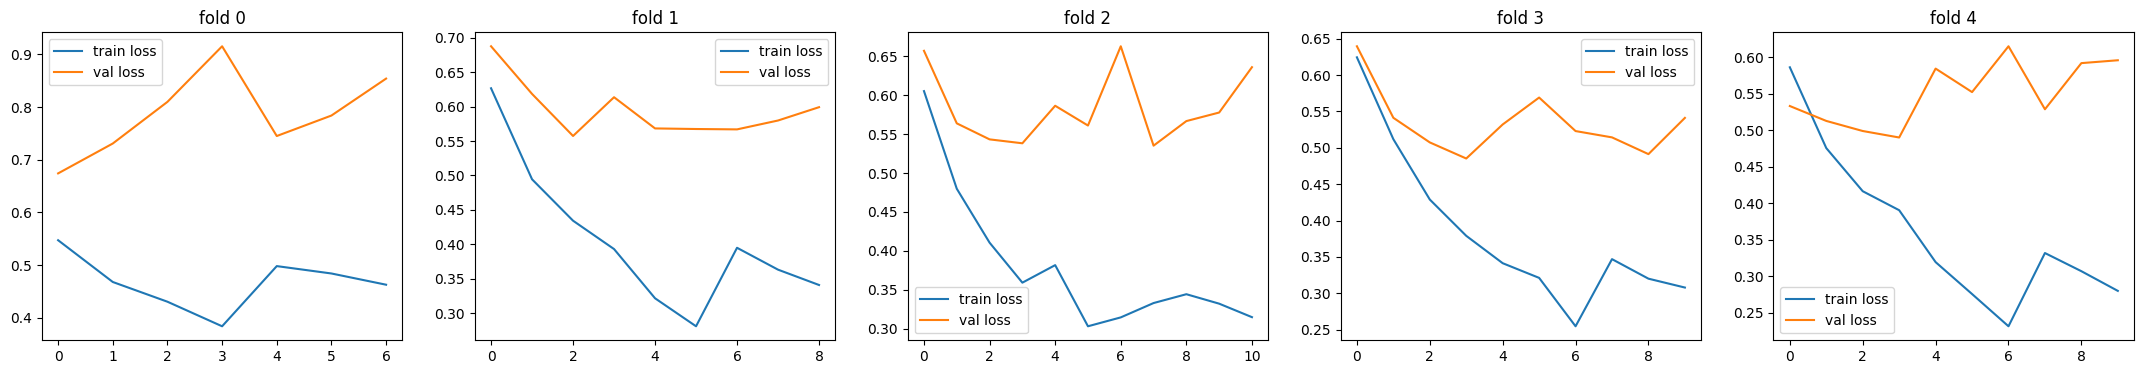

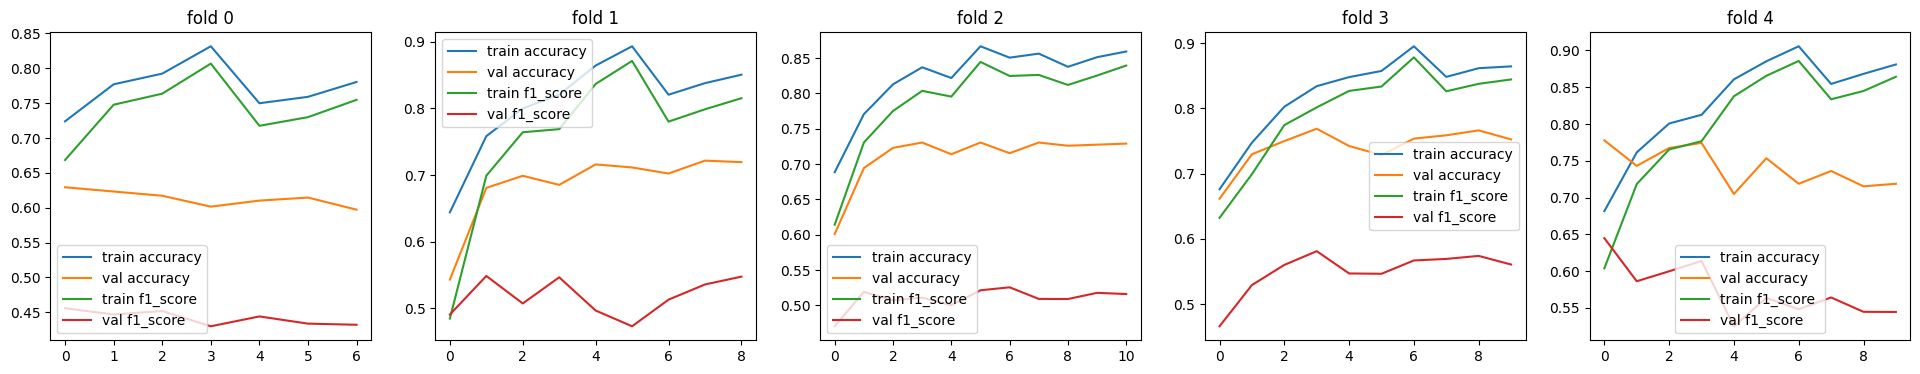

In [ ]:
_, axs = plt.subplots(ncols = len(roberta_models), figsize=(27, 4)) 
for fold, train_data in enumerate(roberta_models):
    temp_list = [t["loss"] for t in train_data["data"]["train"]]
    train_metric = []
    for l in temp_list:
        train_metric += l
    temp_list = [t["loss"] for t in train_data["data"]["val"]]
    val_metric = []
    for l in temp_list:
        val_metric += l
    x = [i for i in range(len(val_metric))]
    axs[fold].plot(x, train_metric, label="train loss")
    axs[fold].plot(x, val_metric, label="val loss")
    axs[fold].set_title(f"fold {fold}")
    axs[fold].legend()
print("Roberta models:")
plt.show()
_, axs = plt.subplots(ncols = len(roberta_models), figsize=(24, 4)) 
for fold, train_data in enumerate(roberta_models):
    for metric in ["accuracy", "f1_score"]:
        temp_list = [t[metric] for t in train_data["data"]["train"]]
        train_metric = []
        for l in temp_list:
            train_metric += l
        temp_list = [t[metric] for t in train_data["data"]["val"]]
        val_metric = []
        for l in temp_list:
            val_metric += l
        x = [i for i in range(len(val_metric))]
        axs[fold].plot(x, train_metric, label=f"train {metric}")
        axs[fold].plot(x, val_metric, label=f"val {metric}")
        axs[fold].set_title(f"fold {fold}")
        axs[fold].legend()
plt.show()

In [ ]:
best_model_fold['model']

Model(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [ ]:
#torch.save(best_model_fold['model'].state_dict(), 'best model')

model.load_state_dict(torch.load('best model'))

<All keys matched successfully>

In [ ]:
best_model = Model(2, LEGAL_BERT)
best_model.load_state_dict(best_model_fold["model"].state_dict())#est_model_fold["model"].state_dict())
best_model = best_model.to(device)
best_model.eval()

Model(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [ ]:
def full_test(model, cases):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for case in cases:
            clauses = case["all_clauses"]
            args_set = set()
            splitter = "AS TO THE LAW" if "AS TO THE LAW" in case["text"] else "THE LAW"
            law_section = case["text"].split(splitter)[1]
            for argument in case["arguments"]:
                if (argument["conclusion"] not in args_set) and (clauses[argument["conclusion"]] in law_section):
                    tokenized_x = tokenizer(clauses[argument["conclusion"]],padding = True, truncation=True, return_tensors='pt')
                    tokenized_x = {key: tokenized_x[key].to(device) for key in tokenized_x.keys()}
                    pred = model(tokenized_x)
                    y_pred.append(torch.max(pred, -1)[1].view(-1).cpu().tolist()[0])
                    #y_pred.append(1)
                    y_true.append(0)
                    keys = list(tokenized_x.keys())
                    for k in keys:
                        del tokenized_x[k]
                    del tokenized_x
                    args_set.add(argument["conclusion"])
                elif argument["conclusion"] not in args_set and clauses[argument["conclusion"]] not in law_section:
                    args_set.add(argument["conclusion"])
                    y_pred.append(1)
                    y_true.append(0)
                for premise in argument["premises"]:
                    if premise not in args_set and clauses[premise] in law_section:
                        tokenized_x = tokenizer(clauses[premise], padding = True, truncation=True, return_tensors='pt')
                        tokenized_x = {key: tokenized_x[key].to(device) for key in tokenized_x.keys()}
                        pred = model(tokenized_x)
                        y_pred.append(torch.max(pred, -1)[1].view(-1).cpu().tolist()[0])
                        #y_pred.append(1)
                        y_true.append(0)
                        keys = list(tokenized_x.keys())
                        for k in keys:
                            del tokenized_x[k]
                        del tokenized_x
                        args_set.add(premise)
                        
                    elif premise not in args_set and clauses[premise] not in law_section:
                        args_set.add(premise)
                        y_pred.append(1)
                        y_true.append(0)
            for clause_id in clauses.keys():
                if (not clause_id in args_set) and (clauses[clause_id] in law_section):
                    tokenized_x = tokenizer(clauses[clause_id], padding = True, truncation=True, return_tensors='pt')
                    tokenized_x = {key: tokenized_x[key].to(device) for key in tokenized_x.keys()}
                    pred = model(tokenized_x)
                    y_pred.append(torch.max(pred, -1)[1].view(-1).cpu().tolist()[0])
                    #y_pred.append(0)
                    y_true.append(1)
                    keys = list(tokenized_x.keys())
                    for k in keys:
                        del tokenized_x[k]
                    del tokenized_x
                    args_set.add(clause_id)
                    
                if (not clause_id in args_set) and (clauses[clause_id] not in law_section):
                    y_pred.append(1)
                    y_true.append(1)
    print(f"""accuracy: {accuracy_score(y_true, y_pred):.2f}
    f1: {f1_score(y_true, y_pred):.2f}
    precision: {precision_score(y_true, y_pred):.2f}
    recall: {recall_score(y_true, y_pred):.2f}""")
full_test(best_model, test_cases)

accuracy: 0.86
    f1: 0.89
    precision: 0.93
    recall: 0.85


## 6.2 Argument Relation Mining

In [16]:
def get_arm_dataloader(cases, tokenizer, batch_size=16, shuffle=False, verbose=True):
    args_set = set()    #Prepare ids of clauses that are parts of arguments
    for case in refactored_dataset: # for each case
        for argument in case["arguments"]: 
            args_set.add(argument["conclusion"])
            for premise in argument["premises"]:
                args_set.add(premise)

    ARM_x = []
    ARM_y = []
    for case in cases:
        clause_pos={}
        for clause in case['all_clauses']:
            clause_pos[clause] = case['text'].find(case['all_clauses'][clause])
        sorted_clauses = sorted(clause_pos.items(), key=lambda kv: kv[1])

        for el1 in range(len(sorted_clauses)-1):
            if sorted_clauses[el1][0] in args_set:
                for el2 in sorted_clauses[el1+1:el1+6]:
                    if el2[0] in args_set:
                        ARM_x.append({'e1': case['all_clauses'][sorted_clauses[el1][0]], 'e2': case['all_clauses'][el2[0]]})
                        y = torch.tensor([0., 1.])
                        for arg in case['arguments']:
                            if sorted_clauses[el1][0] in arg['premises'] or sorted_clauses[el1][0] == arg['conclusion']:
                                if el2[0] in arg['premises'] or el2[0] == arg['conclusion']:
                                    y = torch.tensor([1., 0.])
                        ARM_y.append(y)
    firsts = [el["e1"] for el in ARM_x]
    seconds = [el["e2"] for el in ARM_x]
    firsts = tokenizer.batch_encode_plus(
    firsts,
    add_special_tokens=True,
    padding = True,
    truncation=True,
    return_tensors='pt'
    )
    seconds = tokenizer.batch_encode_plus(
    seconds,
    add_special_tokens=True,
    padding = True,
    truncation=True,
    return_tensors='pt'
    )
    firsts = dict_lists_to_list_of_dicts(firsts)
    seconds = dict_lists_to_list_of_dicts(seconds)
    ARM_x_tokenized = [{"e1": firsts[i], "e2": seconds[i]} for i in range(len(firsts))]
    dataset = Dataset(ARM_x_tokenized, ARM_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

ARM_train_dataloader = get_arm_dataloader(train_cases, tokenizer, shuffle=True, batch_size=8)
ARM_validation_dataloder = get_arm_dataloader(validation_cases, tokenizer, batch_size=8)
ARM_test_dataloader = get_arm_dataloader(test_cases, tokenizer, batch_size=8)

### Train

Model1 prende le due componenti e le analizza indipendentemente per poi dare un output

Molel2 concatena componente 1 e componente 2 per analizzarle assieme

In [17]:
class Model1(NeuralNetwork):
    def __init__(self, out_features:int, bert_type:str, dropout:float = .2) -> None:
        super().__init__()
        self.encoder = AutoModel.from_pretrained(bert_type)
        self.output_layer = nn.Linear(self.encoder.config.hidden_size * 2, out_features)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input):
        encoded_input_1, _ = self.encoder(**input["e1"], return_dict = False)
        encoded_input_2, _ = self.encoder(**input["e2"], return_dict = False)
        
        encoded_input_1 = torch.nn.functional.avg_pool1d(
            encoded_input_1.permute(0, 2, 1), 
            kernel_size=encoded_input_1.size(1)
        ).squeeze(2)
        encoded_input_2 = torch.nn.functional.avg_pool1d(
            encoded_input_2.permute(0, 2, 1), 
            kernel_size=encoded_input_2.size(1)
        ).squeeze(2)
        encoded_input = self.dropout(torch.cat((encoded_input_1, encoded_input_2), dim=1))
        if len(encoded_input.size()) != 2:
            print(encoded_input.size())
        return self.output_layer(encoded_input).float()
    
class Model2(NeuralNetwork):
    def __init__(self, out_features:int, bert_type:str, dropout:float = .3) -> None:
        super().__init__()
        self.encoder = AutoModel.from_pretrained(bert_type)
        self.output_layer = nn.Linear(self.encoder.config.hidden_size, out_features)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input):
        input = {key: torch.cat((input["e1"][key], input["e2"][key]), dim=1) for key in input["e1"].keys()}
        encoded_input, _ = self.encoder(**input, return_dict = False)
        encoded_input = self.dropout(encoded_input)
        encoded_input = torch.nn.functional.avg_pool1d(
            encoded_input.permute(0, 2, 1), 
            kernel_size=encoded_input.size(1)
        ).squeeze(2)
        if len(encoded_input.size()) != 2:
            print(encoded_input.size())
        return self.output_layer(encoded_input).float()
    

In [18]:
legal_bert_models_model_1 = fold_training(cases, LEGAL_BERT, 5e-7, 1e-6, .6, get_arm_dataloader, Model1)

learning rate = 1e-06
EPOCH 1 training loss:      0.624 - validation loss:      0.554                                                                                                                                                                                                                                                      
EPOCH 1 training accuracy:      0.666 - validation accuracy:      0.766
EPOCH 1 training f1_score:      0.571 - validation f1_score:      0.527
----------------------------------------------------------------------------------------------------

EPOCH 2 training loss:      0.568 - validation loss:      0.529                                                                                                                                                                                                                                                      
EPOCH 2 training accuracy:      0.711 - validation accuracy:      0.765
EPOCH 2 training f1_score:      0.633 - 

In [19]:
for i, model_data in enumerate(legal_bert_models_model_1):
    f = open(f"trainings/6.2/legal_bert_m1_fold_{i}.json","w")
    for data in model_data["data"]["train"]:
        data["loss"] = [float(l) for l in data["loss"]]
    for data in model_data["data"]["val"]:
        data["loss"] = [float(l) for l in data["loss"]]
    json.dump(model_data["data"], f)
    f.close()
for i, model_info in enumerate(legal_bert_models_model_1):
    torch.save(model_info["model"].state_dict(), f"weights/6.2/best_model_legal_bert_m1_fold_{i}")

In [18]:
legal_bert_models_model_2 = fold_training(cases, LEGAL_BERT, 5e-7, 1e-6, .6, get_arm_dataloader, Model2)

learning rate = 1e-06
EPOCH 1 training loss:      0.611 - validation loss:      0.562                                                                                                                                                                                                                                                      
EPOCH 1 training accuracy:      0.651 - validation accuracy:      0.741
EPOCH 1 training f1_score:      0.611 - validation f1_score:      0.531
----------------------------------------------------------------------------------------------------

EPOCH 2 training loss:      0.529 - validation loss:      0.534                                                                                                                                                                                                                                                      
EPOCH 2 training accuracy:      0.729 - validation accuracy:      0.760
EPOCH 2 training f1_score:      0.690 - 

In [19]:
for i, model_data in enumerate(legal_bert_models_model_2):
    f = open(f"trainings/6.2/legal_bert_m2_fold_{i}.json","w")
    for data in model_data["data"]["train"]:
        data["loss"] = [float(l) for l in data["loss"]]
    for data in model_data["data"]["val"]:
        data["loss"] = [float(l) for l in data["loss"]]
    json.dump(model_data["data"], f)
    f.close()
for i, model_info in enumerate(legal_bert_models_model_2):
    torch.save(model_info["model"].state_dict(), f"weights/6.2/best_model_legal_bert_m2_fold_{i}")
    model_info["model"] = model_info["model"].to("cpu")

In [27]:
roberta_models_m1 = fold_training(cases, ROBERTA, 2e-6, 6e-6, .6, get_arm_dataloader, Model1) #Intorno a 4e-6 ho osservato che impara, sto provando 3 learning rate intorno a quel valore

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


learning rate = 6e-06
batch 757/880 ----- loss:      0.522 ----- accuracy:      0.719 ----- f1_score:      0.705

In [ ]:
for i, model_data in enumerate(roberta_models_m1):
    f = open(f"trainings/6.2/roberta_m1_fold_{i}.json","w")
    for data in model_data["data"]["train"]:
        data["loss"] = [float(l) for l in data["loss"]]
    for data in model_data["data"]["val"]:
        data["loss"] = [float(l) for l in data["loss"]]
    json.dump(model_data["data"], f)
    f.close()
for i, model_info in enumerate(roberta_models_m1):
    torch.save(model_info["model"].state_dict(), f"weights/6.2/best_model_roberta_m1_fold_{i}")
    model_info["model"] = model_info["model"].to("cpu")

In [18]:
roberta_models_m2 = fold_training(cases, ROBERTA, 2e-6, 6e-6, .6, get_arm_dataloader, Model2)
for i, model_data in enumerate(roberta_models_m2):
    f = open(f"trainings/6.2/roberta_m2_fold_{i}.json","w")
    for data in model_data["data"]["train"]:
        data["loss"] = [float(l) for l in data["loss"]]
    for data in model_data["data"]["val"]:
        data["loss"] = [float(l) for l in data["loss"]]
    json.dump(model_data["data"], f)
    f.close()
for i, model_info in enumerate(roberta_models_m2):
    torch.save(model_info["model"].state_dict(), f"weights/6.2/best_model_roberta_m2_fold_{i}")
    model_info["model"] = model_info["model"].to("cpu")

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EPOCH 1 training loss:      0.479 - validation loss:      0.528                                                                                                                                                                                                                                                      
EPOCH 1 training accuracy:      0.839 - validation accuracy:      0.803
EPOCH 1 training f1_score:      0.561 - validation f1_score:      0.531
----------------------------------------------------------------------------------------------------

EPOCH 2 training loss:      0.560 - validation loss:      0.512                                                                                                                                                                                                                                                      
EPOCH 2 training accuracy:      0.786 - validation accuracy:      0.803
EPOCH 2 training f1_score:      0.495 - validation f1_score:  

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EPOCH 1 training loss:      1.531 - validation loss:      1.312                                                                                                                                                                                                                                                      
EPOCH 1 training accuracy:      0.803 - validation accuracy:      0.839
EPOCH 1 training f1_score:      0.494 - validation f1_score:      0.595
----------------------------------------------------------------------------------------------------

EPOCH 2 training loss:      0.991 - validation loss:      0.855                                                                                                                                                                                                                                                      
EPOCH 2 training accuracy:      0.804 - validation accuracy:      0.839
EPOCH 2 training f1_score:      0.519 - validation f1_score:  

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EPOCH 1 training loss:      1.043 - validation loss:      3.404                                                                                                                                                                                                                                                      
EPOCH 1 training accuracy:      0.804 - validation accuracy:      0.396
EPOCH 1 training f1_score:      0.532 - validation f1_score:      0.245
----------------------------------------------------------------------------------------------------

EPOCH 2 training loss:      0.999 - validation loss:      3.251                                                                                                                                                                                                                                                      
EPOCH 2 training accuracy:      0.804 - validation accuracy:      0.396
EPOCH 2 training f1_score:      0.520 - validation f1_score:  

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EPOCH 1 training loss:      1.227 - validation loss:      2.551                                                                                                                                                                                                                                                      
EPOCH 1 training accuracy:      0.804 - validation accuracy:      0.586
EPOCH 1 training f1_score:      0.519 - validation f1_score:      0.389
----------------------------------------------------------------------------------------------------

EPOCH 2 training loss:      0.569 - validation loss:      1.084                                                                                                                                                                                                                                                      
EPOCH 2 training accuracy:      0.804 - validation accuracy:      0.586
EPOCH 2 training f1_score:      0.557 - validation f1_score:  

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EPOCH 1 training loss:      2.645 - validation loss:      5.010                                                                                                                                                                                                                                                      
EPOCH 1 training accuracy:      0.803 - validation accuracy:      0.623
EPOCH 1 training f1_score:      0.518 - validation f1_score:      0.411
----------------------------------------------------------------------------------------------------

EPOCH 2 training loss:      0.878 - validation loss:      1.667                                                                                                                                                                                                                                                      
EPOCH 2 training accuracy:      0.804 - validation accuracy:      0.623
EPOCH 2 training f1_score:      0.507 - validation f1_score:  

In [24]:
for fold in range(5):
    f = open(f"trainings/6.2/legal_bert_m1_fold_{fold}.json")
    data = json.load(f)
    model = Model1(2, LEGAL_BERT)
    model.load_state_dict(torch.load(f"weights/6.2/best_model_legal_bert_m1_fold_{fold}"))
    losses = [train["loss"] for train in data["val"]]
    loss = []
    for l in losses:
        loss += l
    loss = min(loss)
    legal_bert_models_model_1.append({"loss": loss, "data":data, "model": model})

NameError: name 'legal_bert_models_model_1' is not defined

Error during conversion: HTTPError('500 Server Error: Internal Server Error for url: https://safetensors-convert.hf.space/queue/data?fn_index=1&session_hash=a28b0ea4-2dd7-49ef-88c1-195261f3e1e5')


In [21]:
_, axs = plt.subplots(ncols = len(legal_bert_models_model_1), figsize=(27, 4)) 
for fold, train_data in enumerate(legal_bert_models_model_1):
    temp_list = [t["loss"] for t in train_data["data"]["train"]]
    train_metric = []
    for l in temp_list:
        train_metric += l
    temp_list = [t["loss"] for t in train_data["data"]["val"]]
    val_metric = []
    for l in temp_list:
        val_metric += l
    x = [i for i in range(len(val_metric))]
    axs[fold].plot(x, train_metric, label="train loss")
    axs[fold].plot(x, val_metric, label="val loss")
    axs[fold].set_title(f"fold {fold}")
    axs[fold].legend()
print("Legal bert models m1:")
plt.show()
_, axs = plt.subplots(ncols = len(legal_bert_models_model_1), figsize=(24, 4)) 
for fold, train_data in enumerate(legal_bert_models_model_1):
    for metric in ["accuracy", "f1_score"]:
        temp_list = [t[metric] for t in train_data["data"]["train"]]
        train_metric = []
        for l in temp_list:
            train_metric += l
        temp_list = [t[metric] for t in train_data["data"]["val"]]
        val_metric = []
        for l in temp_list:
            val_metric += l
        x = [i for i in range(len(val_metric))]
        axs[fold].plot(x, train_metric, label=f"train {metric}")
        axs[fold].plot(x, val_metric, label=f"val {metric}")
        axs[fold].set_title(f"fold {fold}")
        axs[fold].legend()
plt.show()

NameError: name 'legal_bert_models_model_1' is not defined

In [ ]:
def ARM_full_test(model, cases):
    y_true = []
    y_pred = []
    args_set = set()
    with torch.no_grad():
        for case in cases:
            for argument in case["arguments"]:
                if (argument["conclusion"] not in args_set) and (clauses[argument["conclusion"]] in law_section):
                    tokenized_x = tokenizer(clauses[argument["conclusion"]],padding = True, truncation=True, return_tensors='pt')
                    tokenized_x = {key: tokenized_x[key].to(device) for key in tokenized_x.keys()}
                    pred = model(tokenized_x)
                    y_pred.append(1 - torch.max(pred, -1)[1].view(-1).cpu().tolist()[0])
                    #y_pred.append(1)
                    y_true.append(0)
                    keys = list(tokenized_x.keys())
                    for k in keys:
                        del tokenized_x[k]
                    del tokenized_x
                    args_set.add(argument["conclusion"])
                elif argument["conclusion"] not in args_set and clauses[argument["conclusion"]] not in law_section:
                    args_set.add(argument["conclusion"])
                    y_pred.append(1)
                    y_true.append(0)
                for premise in argument["premises"]:
                    if premise not in args_set and clauses[premise] in law_section:
                        tokenized_x = tokenizer(clauses[premise], padding = True, truncation=True, return_tensors='pt')
                        tokenized_x = {key: tokenized_x[key].to(device) for key in tokenized_x.keys()}
                        pred = model(tokenized_x)
                        y_pred.append(torch.max(pred, -1)[1].view(-1).cpu().tolist()[0])
                        #y_pred.append(1)
                        y_true.append(0)
                        keys = list(tokenized_x.keys())
                        for k in keys:
                            del tokenized_x[k]
                        del tokenized_x
                        args_set.add(premise)
                        
                    elif premise not in args_set and clauses[premise] not in law_section:
                        args_set.add(premise)
                        y_pred.append(1)
                        y_true.append(0)
            for clause_id in clauses.keys():
                if (not clause_id in args_set) and (clauses[clause_id] in law_section):
                    tokenized_x = tokenizer(clauses[clause_id], padding = True, truncation=True, return_tensors='pt')
                    tokenized_x = {key: tokenized_x[key].to(device) for key in tokenized_x.keys()}
                    pred = model(tokenized_x)
                    y_pred.append(torch.max(pred, -1)[1].view(-1).cpu().tolist()[0])
                    #y_pred.append(0)
                    y_true.append(1)
                    keys = list(tokenized_x.keys())
                    for k in keys:
                        del tokenized_x[k]
                    del tokenized_x
                    args_set.add(clause_id)
                    
                if (not clause_id in args_set) and (clauses[clause_id] not in law_section):
                    y_pred.append(1)
                    y_true.append(1)
    print(y_true)
    print(y_pred)
    print(len(y_true))
    print(f"""accuracy: {accuracy_score(y_true, y_pred):.2f}
    f1: {f1_score(y_true, y_pred):.2f}
    precision: {precision_score(y_true, y_pred):.2f}
    recall: {recall_score(y_true, y_pred):.2f}""")
full_test(best_model, test_cases)

## 6.3 Premise/Conclusion Recognition

In [18]:
train_cases, validation_cases, test_cases = cases[-1]
def get_pcr_dataloader(cases, tokenizer, batch_size=16, shuffle=False, verbose=True):
    PCR_x = []
    PCR_y = []
    argdict = {}
    for case in cases:
        n_clauses = case["n_clauses"]
        clauses = case["all_clauses"]
        for argument in case["arguments"]:
            if not clauses[argument["conclusion"]] in argdict:
                argdict[clauses[argument["conclusion"]]] = [0.,1.]
            else:
                argdict[clauses[argument["conclusion"]]][1] = 1.

            for premise in argument["premises"]:
                if not clauses[premise] in argdict:
                    argdict[clauses[premise]] = [1.,0.]
                else:
                    argdict[clauses[premise]][0] = 1.

    items = list(argdict.items())
    print(len(items))
    for item in items:
        PCR_x.append(item[0])
        PCR_y.append(torch.tensor(item[1]))


    PCR_x_tokenized = dict_lists_to_list_of_dicts(tokenizer(PCR_x, padding=True, truncation=True, return_tensors='pt'))
    if verbose:
        print(f"""
    There are:
        - {len(PCR_x)} clauses
        - {len([a for a in PCR_y if a[0] == 1.])} premises
        - {len([a for a in PCR_y if a[1] == 1.])} conclusions
        """)
    
    dataset = Dataset(PCR_x_tokenized, PCR_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

print("train set:")
PCR_train_dataloader = get_pcr_dataloader(train_cases, tokenizer, shuffle=True, batch_size=8)
print("validation set:")
PCR_validation_dataloader = get_pcr_dataloader(validation_cases, tokenizer, batch_size=8)
print("test set:")
PCR_test_dataloader = get_pcr_dataloader(test_cases, tokenizer, batch_size=8)

train set:
1607

    There are:
        - 1607 clauses
        - 1279 premises
        - 451 conclusions
        
validation set:
199

    There are:
        - 199 clauses
        - 157 premises
        - 62 conclusions
        
test set:
561

    There are:
        - 561 clauses
        - 441 premises
        - 155 conclusions
        


In [17]:
class ModelPCR(NeuralNetwork):
    def __init__(self, out_features:int, bert_type:str, dropout:float = 0.2) -> None:
        super().__init__()
        if bert_type == ROBERTA:
            self.encoder = RobertaModel.from_pretrained(bert_type)
        else:     
            self.encoder = AutoModel.from_pretrained(bert_type)
        self.output_layer = nn.Linear(self.encoder.config.hidden_size, out_features)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input):
        encoded_input, _ = self.encoder(**input, return_dict = False)
        encoded_input = self.dropout(encoded_input)
        encoded_input = torch.nn.functional.avg_pool1d(
            encoded_input.permute(0, 2, 1), 
            kernel_size=encoded_input.size(1)
        ).squeeze(2)
        return self.output_layer(encoded_input).float()

    def freeze_bert(self):
        for param in self.encoder.parameters():
                param.requires_grad = False
    def unfreeze_bert(self):
        for param in self.encoder.parameters():
                param.requires_grad = True

In [18]:
legal_bert_models = fold_training(cases, LEGAL_BERT, 5e-7, 1e-6, .6, get_pcr_dataloader, ModelPCR, loss=nn.BCEWithLogitsLoss())

1592
214
EPOCH 1 training loss:      0.513 - validation loss:      0.619                                                                                                                                                                                                                                                      
EPOCH 1 training accuracy:      0.802 - validation accuracy:      0.747
EPOCH 1 training f1_score:      0.515 - validation f1_score:      0.462
----------------------------------------------------------------------------------------------------

EPOCH 2 training loss:      0.421 - validation loss:      0.552                                                                                                                                                                                                                                                      
EPOCH 2 training accuracy:      0.838 - validation accuracy:      0.742
EPOCH 2 training f1_score:      0.667 - validation f1

In [19]:
for i, model_data in enumerate(legal_bert_models):
    f = open(f"trainings/6.3/legal_bert_fold_{i}.json","w")
    for data in model_data["data"]["train"]:
        data["loss"] = [float(l) for l in data["loss"]]
    for data in model_data["data"]["val"]:
        data["loss"] = [float(l) for l in data["loss"]]
    json.dump(model_data["data"], f)
    f.close()
for i, model_info in enumerate(legal_bert_models):
    torch.save(model_info["model"].state_dict(), f"weights/6.3/best_model_legal_bert_fold_{i}")
    model_info["model"] = model_info["model"].to("cpu")

In [19]:
roberta_models = fold_training(cases, ROBERTA, 2e-7, 6e-6, .6, get_pcr_dataloader, ModelPCR, loss=nn.BCEWithLogitsLoss())
for i, model_data in enumerate(roberta_models):
    f = open(f"trainings/6.3/roberta_fold_{i}.json","w")
    for data in model_data["data"]["train"]:
        data["loss"] = [float(l) for l in data["loss"]]
    for data in model_data["data"]["val"]:
        data["loss"] = [float(l) for l in data["loss"]]
    json.dump(model_data["data"], f)
    f.close()
for i, model_info in enumerate(roberta_models):
    torch.save(model_info["model"].state_dict(), f"weights/6.3/best_model_roberta_fold_{i}")
    model_info["model"] = model_info["model"].to("cpu")

1592
214


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


learning rate = 6e-06
EPOCH 1 training loss:      0.427 - validation loss:      0.601                                                                                                                                                                                                                                                      
EPOCH 1 training accuracy:      0.839 - validation accuracy:      0.724
EPOCH 1 training f1_score:      0.680 - validation f1_score:      0.578
----------------------------------------------------------------------------------------------------

EPOCH 2 training loss:      0.413 - validation loss:      0.557                                                                                                                                                                                                                                                      
EPOCH 2 training accuracy:      0.823 - validation accuracy:      0.761
EPOCH 2 training f1_score:      0.584 - 

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


learning rate = 6e-06
EPOCH 1 training loss:      0.391 - validation loss:      0.539                                                                                                                                                                                                                                                      
EPOCH 1 training accuracy:      0.839 - validation accuracy:      0.814
EPOCH 1 training f1_score:      0.658 - validation f1_score:      0.596
----------------------------------------------------------------------------------------------------

EPOCH 2 training loss:      0.307 - validation loss:      0.432                                                                                                                                                                                                                                                      
EPOCH 2 training accuracy:      0.862 - validation accuracy:      0.801
EPOCH 2 training f1_score:      0.782 - 

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


learning rate = 6e-06
EPOCH 1 training loss:      0.449 - validation loss:      0.444                                                                                                                                                                                                                                                      
EPOCH 1 training accuracy:      0.843 - validation accuracy:      0.841
EPOCH 1 training f1_score:      0.690 - validation f1_score:      0.575
----------------------------------------------------------------------------------------------------

EPOCH 2 training loss:      0.353 - validation loss:      0.388                                                                                                                                                                                                                                                      
EPOCH 2 training accuracy:      0.856 - validation accuracy:      0.857
EPOCH 2 training f1_score:      0.719 - 

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


learning rate = 6e-06
EPOCH 1 training loss:      0.507 - validation loss:      0.500                                                                                                                                                                                                                                                      
EPOCH 1 training accuracy:      0.827 - validation accuracy:      0.849
EPOCH 1 training f1_score:      0.643 - validation f1_score:      0.628
----------------------------------------------------------------------------------------------------

EPOCH 2 training loss:      0.338 - validation loss:      0.361                                                                                                                                                                                                                                                      
EPOCH 2 training accuracy:      0.869 - validation accuracy:      0.863
EPOCH 2 training f1_score:      0.765 - 

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


learning rate = 6e-06
EPOCH 1 training loss:      0.492 - validation loss:      0.564                                                                                                                                                                                                                                                      
EPOCH 1 training accuracy:      0.798 - validation accuracy:      0.789
EPOCH 1 training f1_score:      0.542 - validation f1_score:      0.518
----------------------------------------------------------------------------------------------------

EPOCH 2 training loss:      0.301 - validation loss:      0.369                                                                                                                                                                                                                                                      
EPOCH 2 training accuracy:      0.862 - validation accuracy:      0.840
EPOCH 2 training f1_score:      0.768 - 

Roberta models:


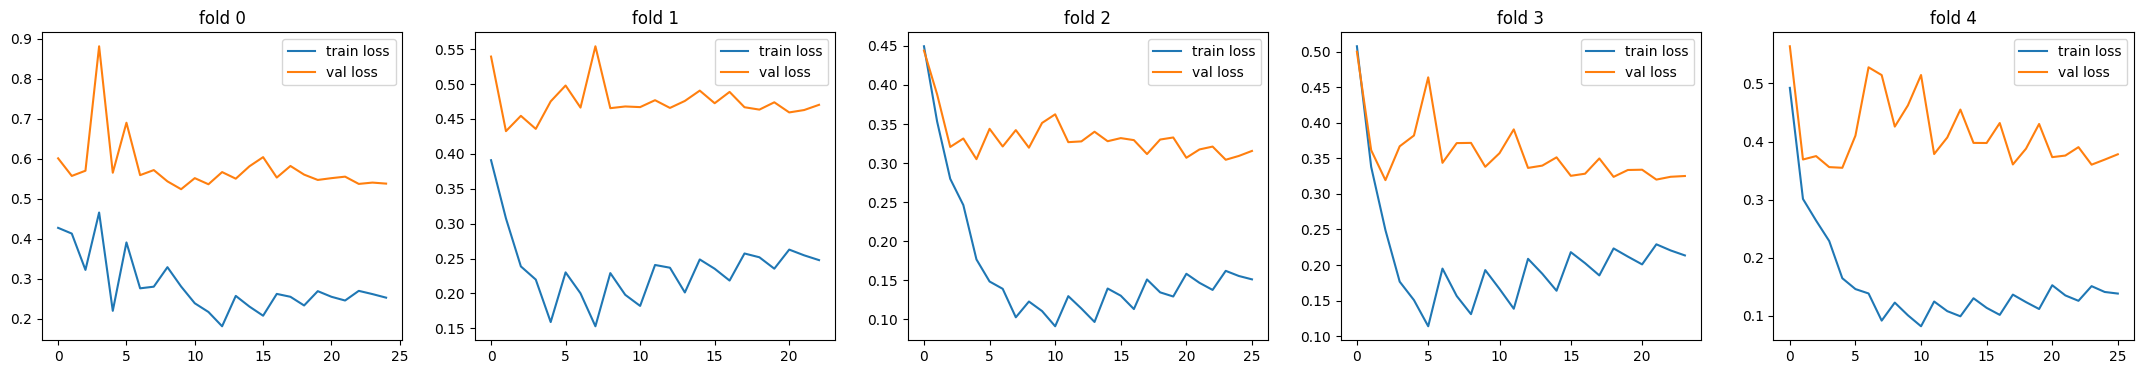

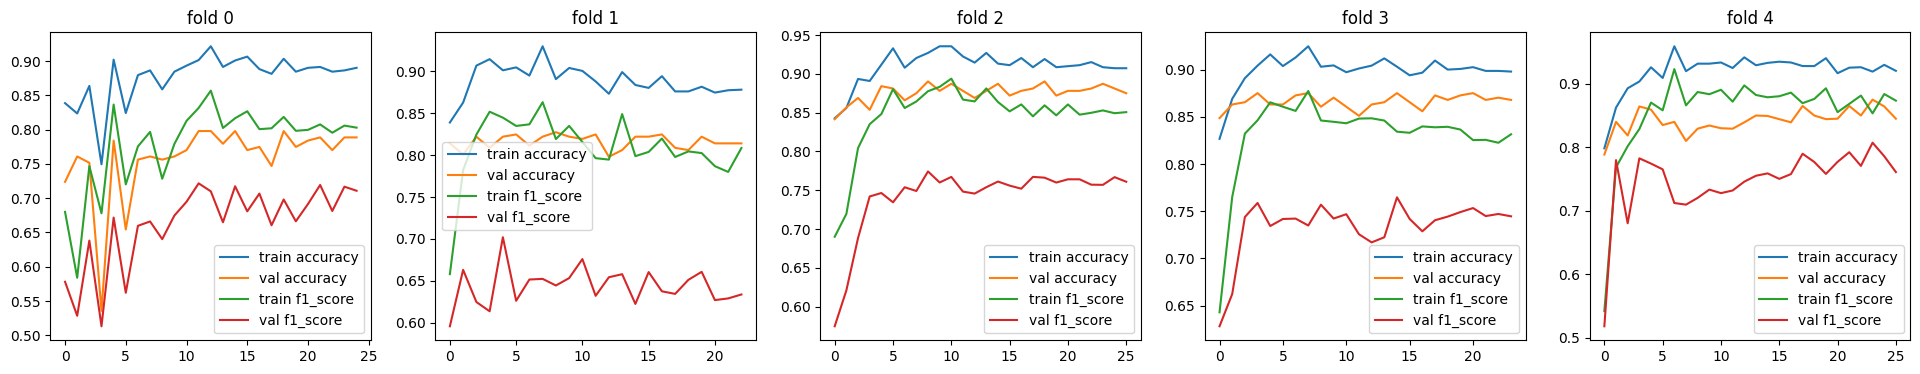

In [20]:
_, axs = plt.subplots(ncols = len(roberta_models), figsize=(27, 4)) 
for fold, train_data in enumerate(roberta_models):
    temp_list = [t["loss"] for t in train_data["data"]["train"]]
    train_metric = []
    for l in temp_list:
        train_metric += l
    temp_list = [t["loss"] for t in train_data["data"]["val"]]
    val_metric = []
    for l in temp_list:
        val_metric += l
    x = [i for i in range(len(val_metric))]
    axs[fold].plot(x, train_metric, label="train loss")
    axs[fold].plot(x, val_metric, label="val loss")
    axs[fold].set_title(f"fold {fold}")
    axs[fold].legend()
print("Roberta models:")
plt.show()
_, axs = plt.subplots(ncols = len(roberta_models), figsize=(24, 4)) 
for fold, train_data in enumerate(roberta_models):
    for metric in ["accuracy", "f1_score"]:
        temp_list = [t[metric] for t in train_data["data"]["train"]]
        train_metric = []
        for l in temp_list:
            train_metric += l
        temp_list = [t[metric] for t in train_data["data"]["val"]]
        val_metric = []
        for l in temp_list:
            val_metric += l
        x = [i for i in range(len(val_metric))]
        axs[fold].plot(x, train_metric, label=f"train {metric}")
        axs[fold].plot(x, val_metric, label=f"val {metric}")
        axs[fold].set_title(f"fold {fold}")
        axs[fold].legend()
plt.show()